In [1]:
%matplotlib inline

import numpy as np
import copy
import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim
seed = cfg_seed
env_str=cfg_env
# num_iter_max=200000
env_name = 'CustomPendulum-v0'
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter2_"

loss_list = []
normalized_loss_list = []

print(datetime.datetime.now())

2023-05-19 18:44:07.977323


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)

2 1 1


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/proxima-hishinuma/anaconda3/

In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_weightedvae_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_pendulum_bamdp_weightedvae_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

# iwvi.load_base(ckpt_key="unweighted")
iwvi.load(ckpt_key="policy_optimization_iter1")

dec: h_dim 48
iwvi load ckpt1, ckpt2 ckpt_iwvi_basepartpendulum_policy_optimization_iter1 ckpt_iwvi_pendulum_policy_optimization_iter1
base load ckpt ckpt_basevi_pendulum_policy_optimization_iter1
base load self.initial_belief.data.sum() tensor(-1.9574)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(-5.2770)
penalty_target_min tensor(-6.1621) penalty_target_max tensor(9.0114)
train_loss:  -4.840517662310601
valid_loss:  -4.816069322967529
h_min_tilde -6.1621222 ell_tilde -4.835627994441987 kappa_tilde 0.0008682550406200986
success load ckpt_iwvi_basepartpendulum_policy_optimization_iter1
train_loss:  -3.800870338749887
valid_loss:  -4.146997798156738
weight_alpha 1.0 h_min_tilde -6.1621222 ell_tilde -3.870095830631257 kappa_tilde 0.0006605264154593137


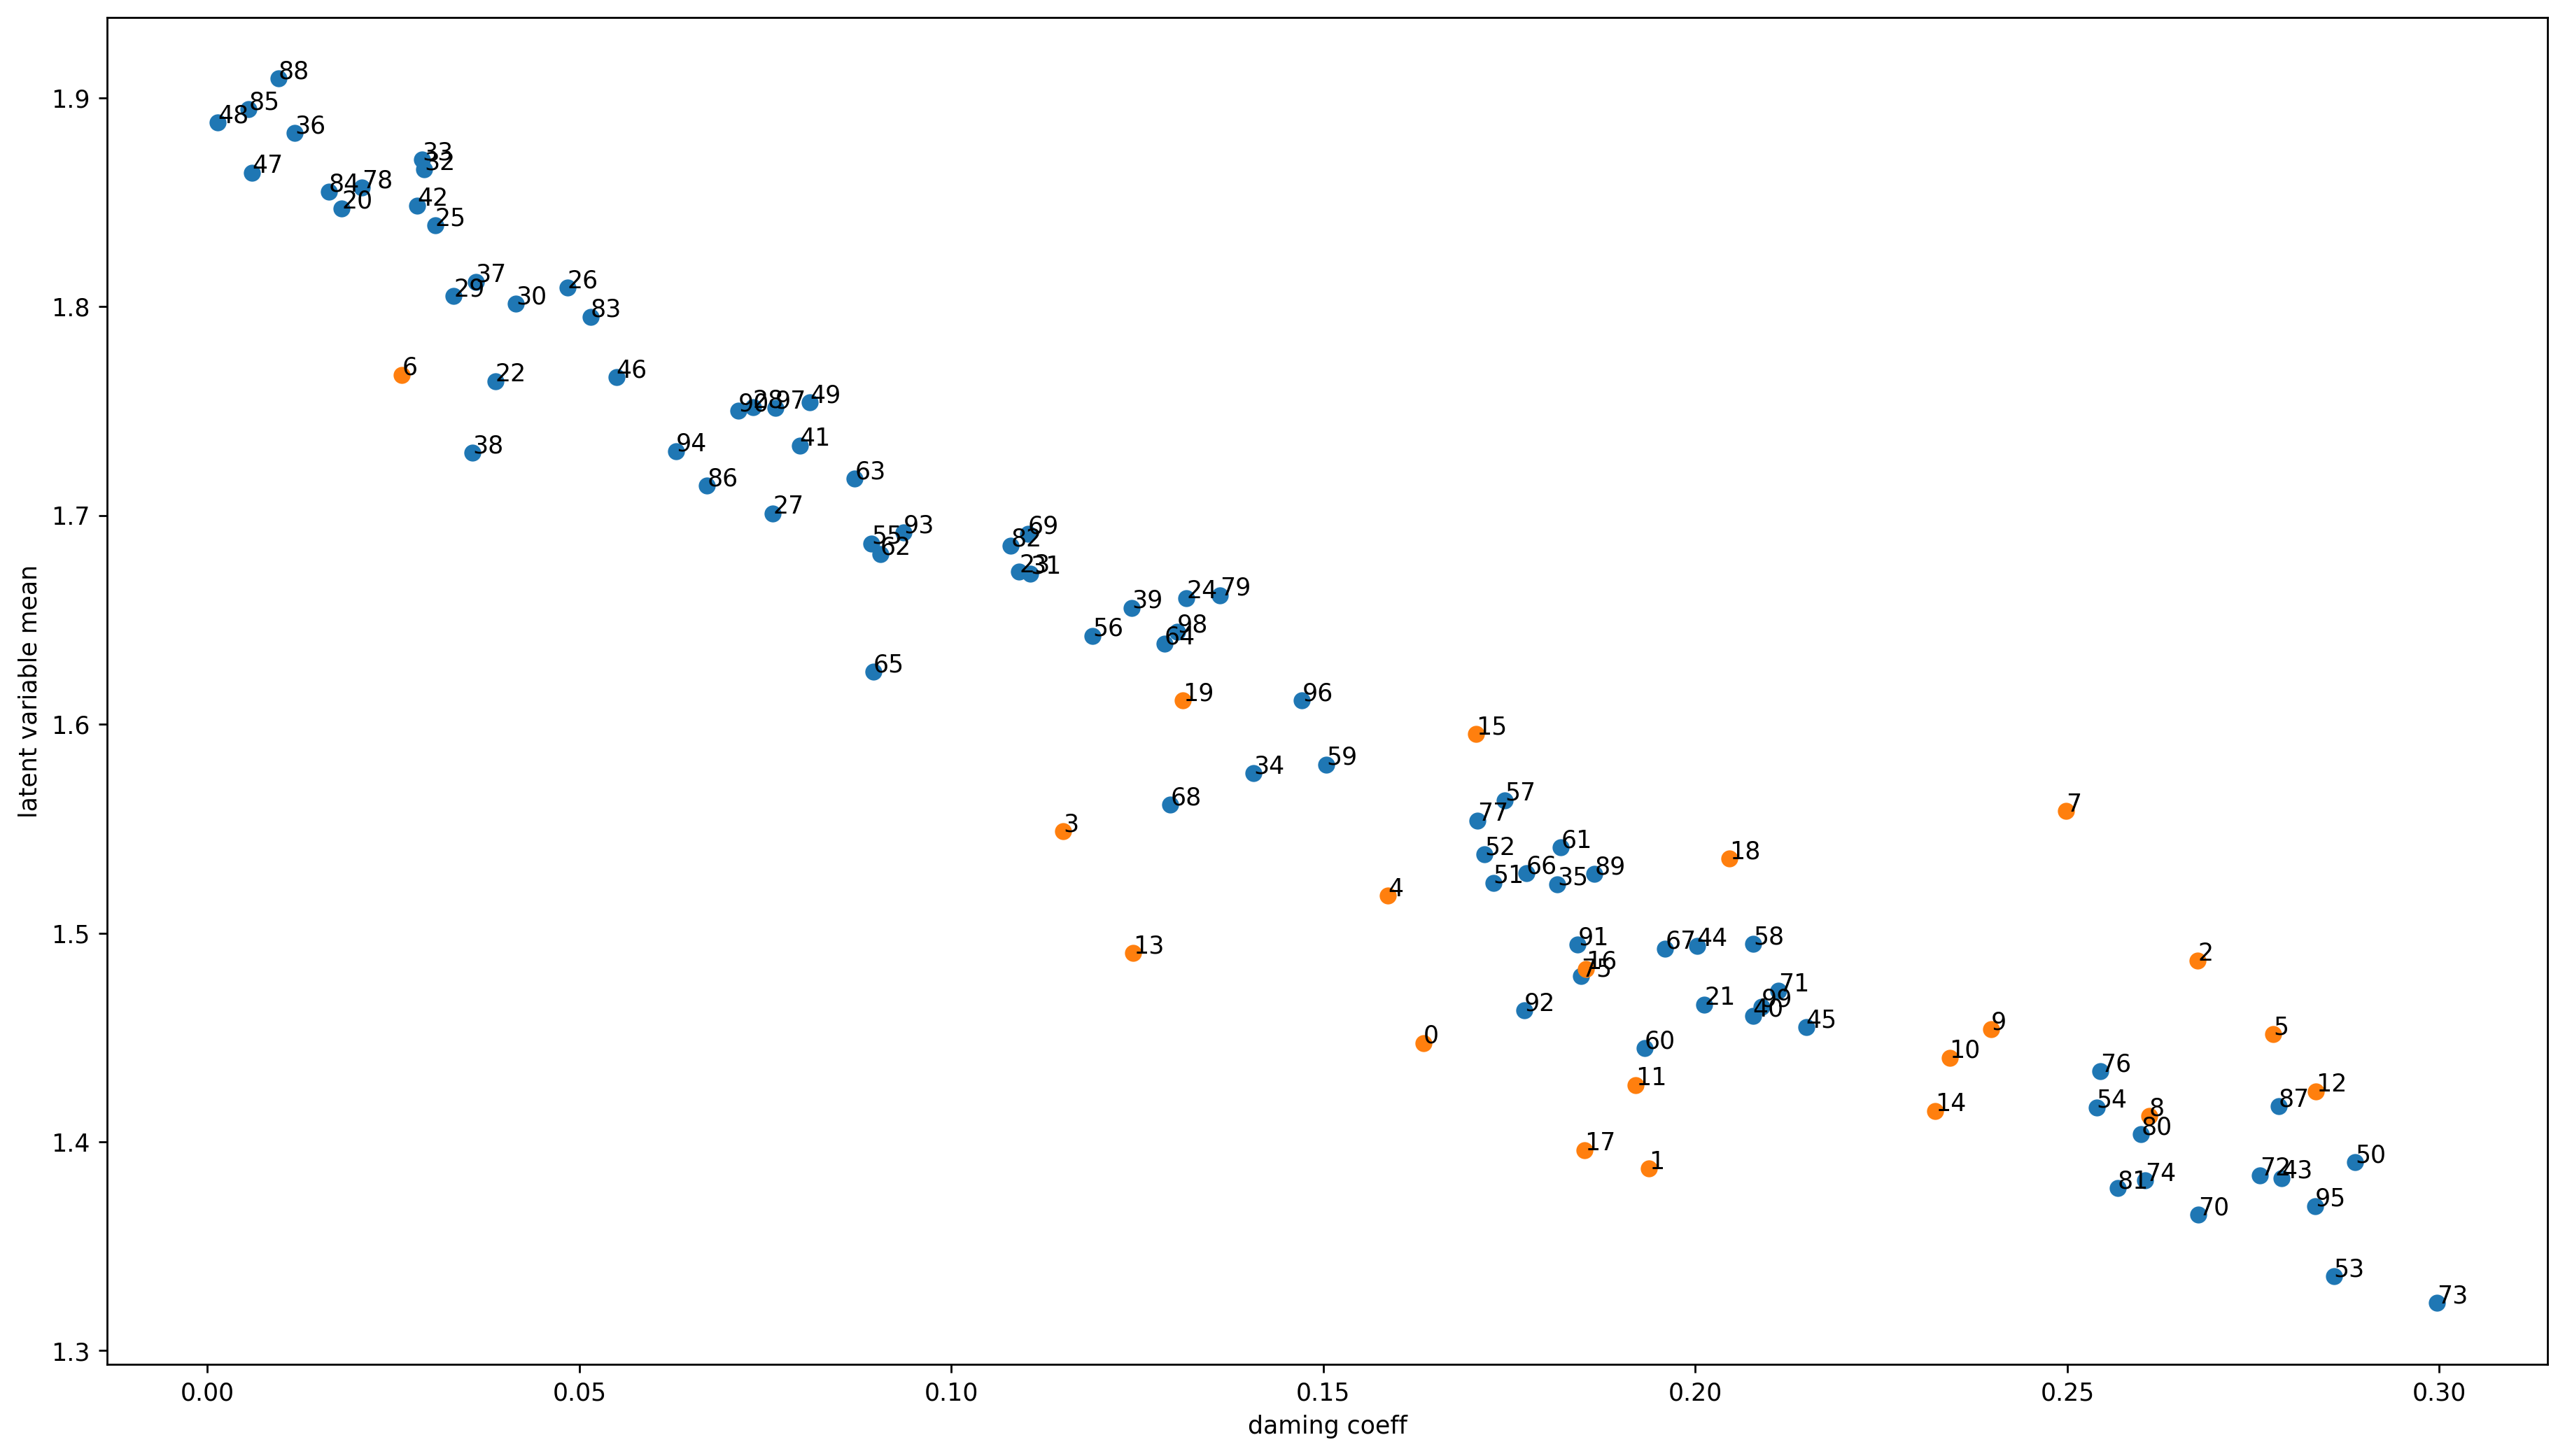

[0.16346495 0.19376823 0.2675319  0.11503246 0.15866848 0.27767899
 0.02613879 0.24978595 0.26100364 0.23974757]
[0.23415875 0.19197631 0.28340068 0.12439858 0.23227011 0.17053018
 0.18529065 0.1850802  0.20454609 0.13110959]
[0.01806764 0.20119136 0.03867789 0.10911323 0.13158045 0.03061344
 0.04839286 0.07598748 0.07332768 0.03311254]
[0.04145489 0.11061755 0.02913038 0.02882952 0.14059536 0.18145366
 0.01175634 0.03605897 0.03561832 0.1242789 ]
[0.20774164 0.07961685 0.02818215 0.27878886 0.20022311 0.21489816
 0.05495741 0.00603226 0.00140864 0.08100239]
[0.28865656 0.1728472  0.17167557 0.2858247  0.2539226  0.08923109
 0.11895172 0.17438186 0.20775948 0.15039731]
[0.19319706 0.18191796 0.09047245 0.08702328 0.12863061 0.0894847
 0.17726183 0.19596025 0.12942553 0.11026856]
[0.26757701 0.21116658 0.27584478 0.2996541  0.26043782 0.18466787
 0.25440247 0.17073022 0.0207501  0.1360628 ]
[0.2599147  0.256741   0.10799342 0.0514889  0.0163014  0.00555654
 0.06717741 0.27842439 0.00955

In [5]:
plt.figure(figsize=(18,10), dpi=250)
np_mulogvar = iwvi.mulogvar_offlinedata.numpy()
plt.xlabel("daming coeff")
plt.ylabel("latent variable mean")

plt.plot(debug_info[iwvi.validdata_num:,1], np_mulogvar[iwvi.validdata_num:,0], "o")
plt.plot(debug_info[:iwvi.validdata_num,1], np_mulogvar[:iwvi.validdata_num,0], "o")
# plt.xlim([-0.05,0.35])
for i in range(len(debug_info)):
    plt.annotate(str(i), xy=(debug_info[i,1],  np_mulogvar[i,0]))
plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.png")
plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.eps")
# plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.pdf")
plt.show()


for i in range(10):
    print(debug_info[i*10 : (i+1)*10,1])
# plt.show()
print("摩擦係数-潜在変数")

In [6]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 7.152557373046875e-07


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:141: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `step()` method is not within the observ


 1 4.3771185874938965

 2 3.1763200759887695

 3 3.4388813972473145

 4 3.385146141052246

 5 4.317624807357788

 6 6.999223232269287

 7 6.946719408035278

 8 6.928303003311157

 9 4.894701719284058

 10 7.377975702285767

 11 6.663907051086426

 12 3.2828049659729004

 13 3.1886425018310547

 14 3.15590500831604

 15 3.2020256519317627

 16 3.0803074836730957

 17 3.2108314037323

 18 3.2261645793914795

 19 3.23612380027771

 20 3.31885027885437

 21 3.4227688312530518

 22 3.4504642486572266

 23 3.6875150203704834

 24 6.886101722717285

 25 6.887235164642334

 26 6.686002731323242

 27 6.991847515106201

 28 6.8499367237091064

 29 5.769502878189087

 30 3.9957425594329834

 31 3.24979567527771

 32 3.154937267303467

 33 3.3022241592407227

 34 3.2422924041748047

 35 5.870124340057373

 36 6.500270128250122

 37 6.791193723678589

 38 4.723899841308594

 39 3.478905200958252

 40 3.2667958736419678

 41 3.0417232513427734

 42 3.3468565940856934

 43 4.481388330459595

 44 7.6

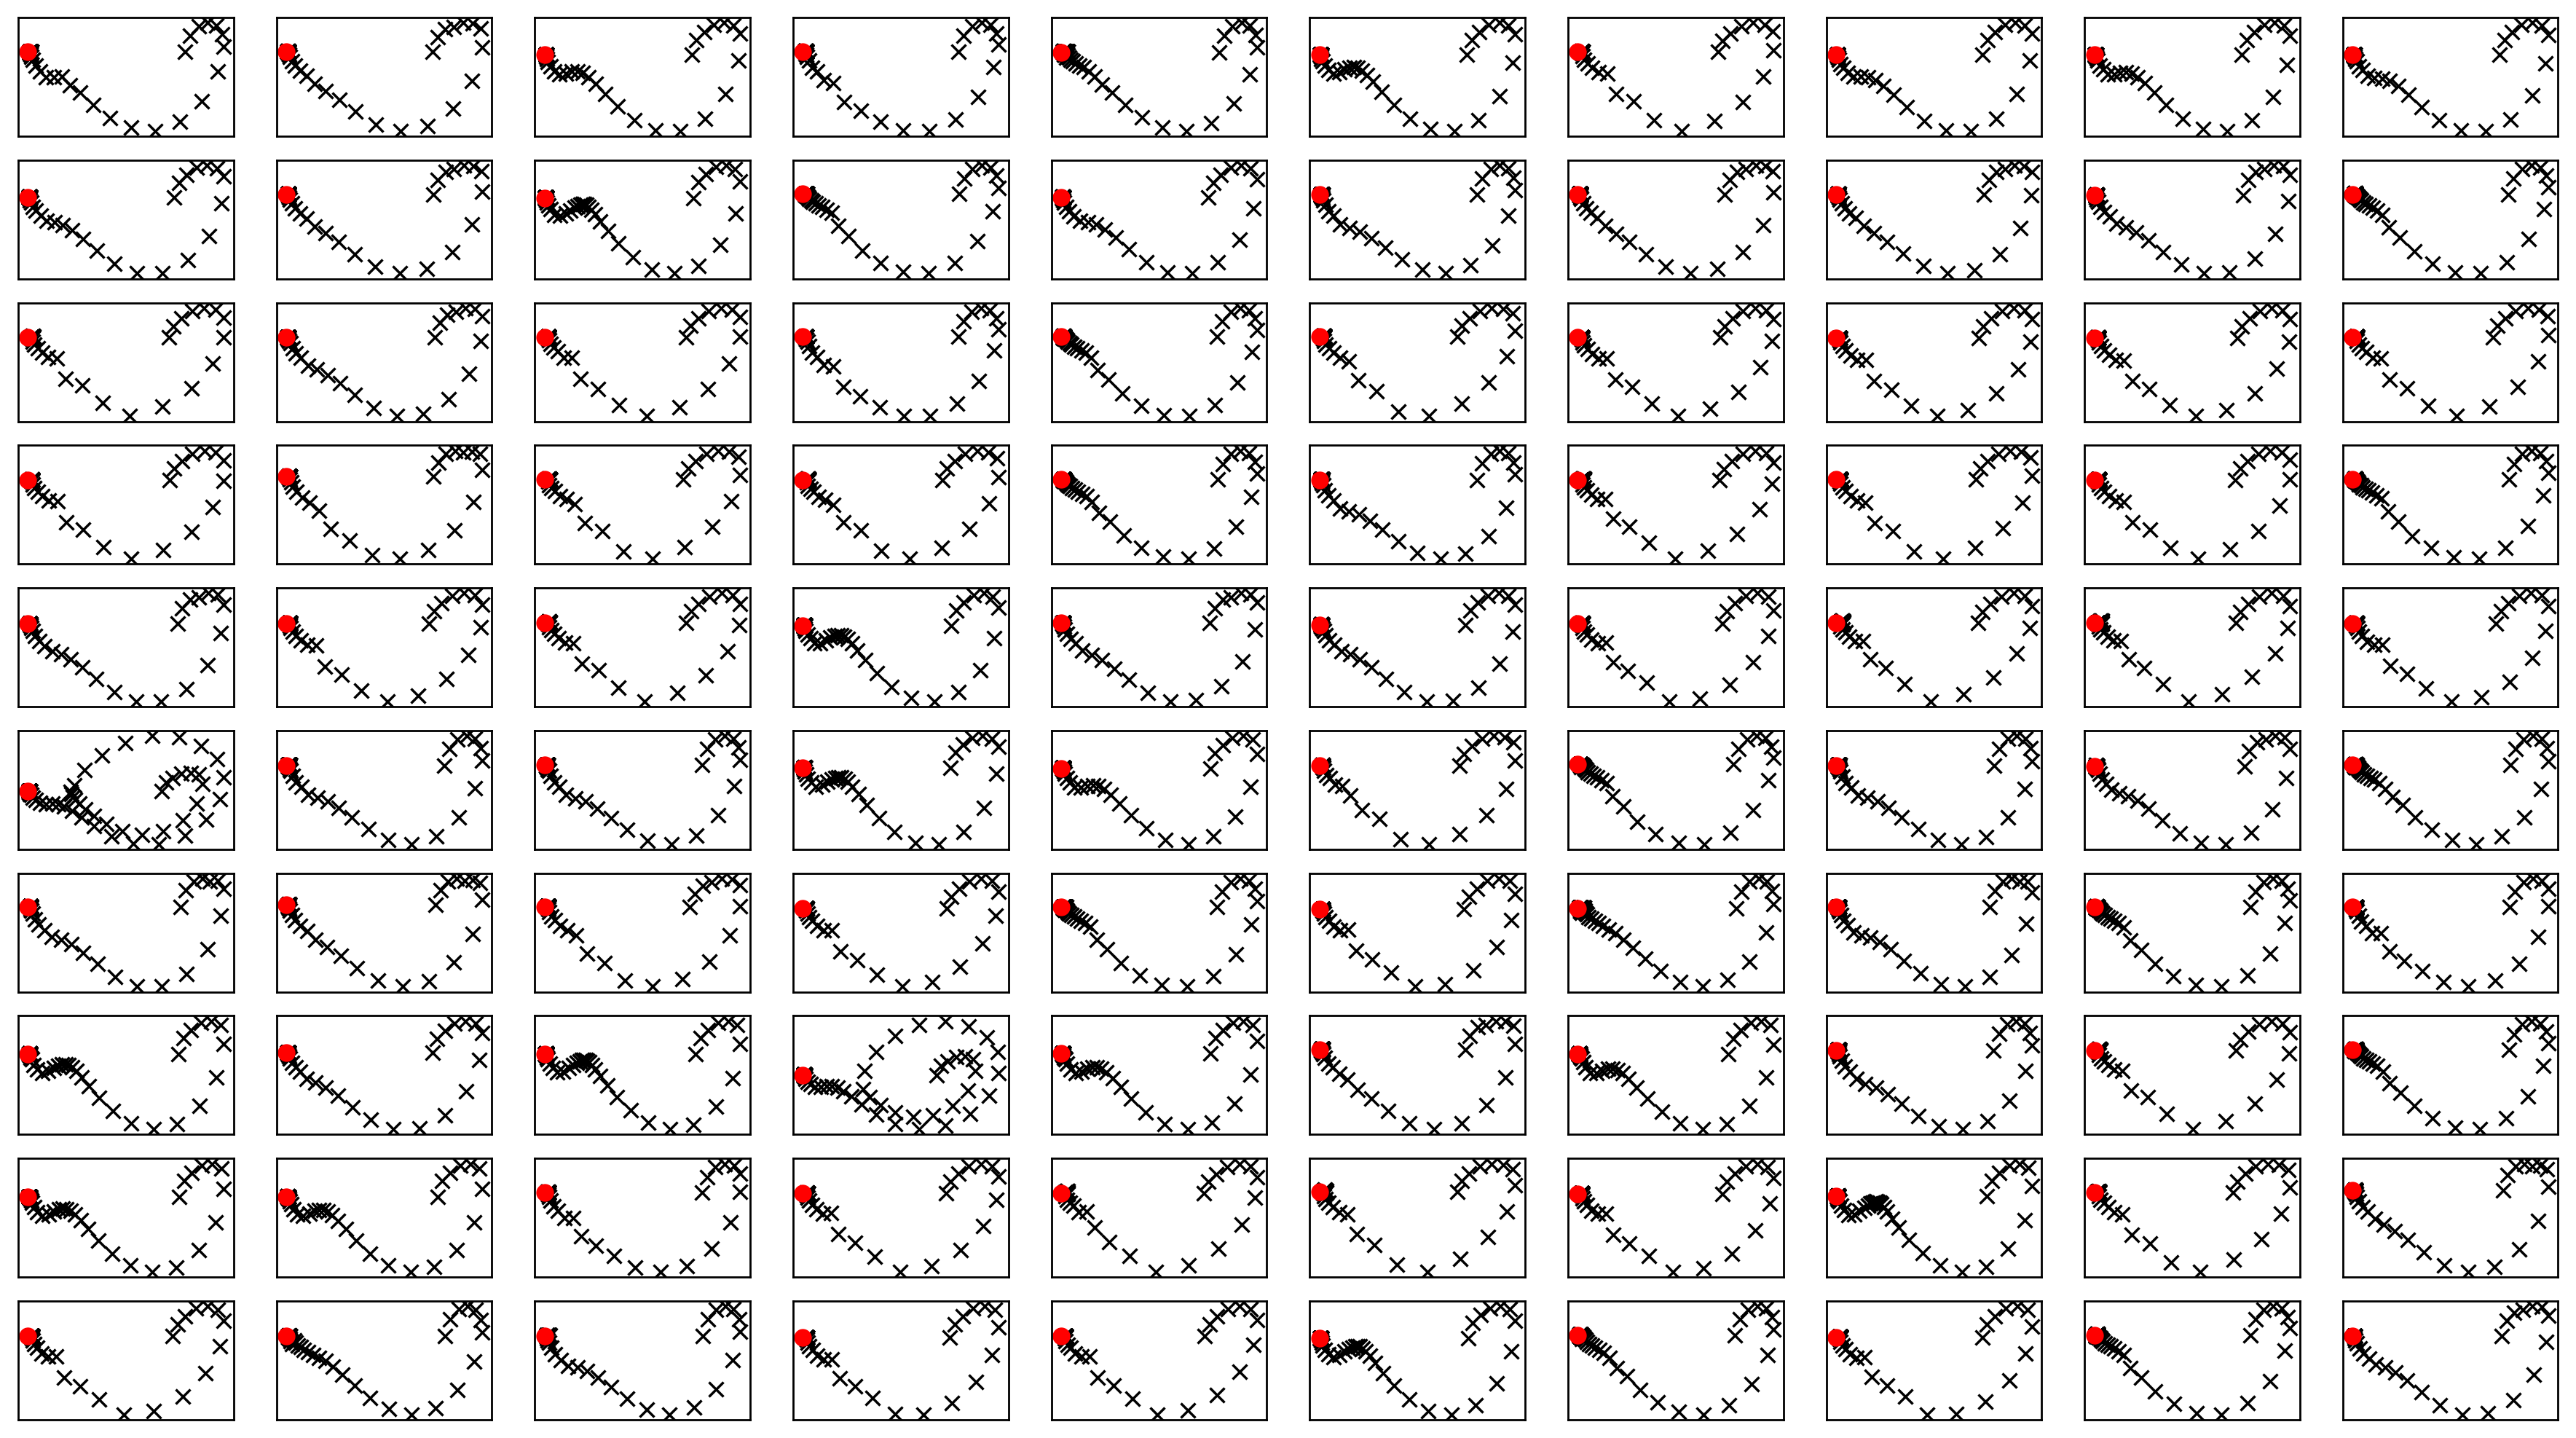

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx") 
    ax_list[-1].plot(0, 0,"ro")
plt.show()

In [8]:
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)


 0 4.76837158203125e-07

 1 3.0434563159942627

 2 3.433353900909424

 3 3.234083890914917

 4 3.055224895477295

 5 3.1577486991882324

 6 3.167132616043091

 7 3.4948363304138184

 8 3.7723817825317383

 9 6.812805414199829

 10 6.723837852478027

 11 6.632538795471191

 12 6.419120788574219

 13 6.6849565505981445

 14 6.597662448883057

 15 6.85312557220459

 16 6.5002546310424805

 17 6.616511344909668

 18 6.604905843734741

 19 6.39718222618103

 20 6.4133734703063965

 21 6.58741021156311

 22 6.5747270584106445

 23 6.362886905670166

 24 6.272493362426758

 25 6.41329288482666

 26 6.452124357223511

 27 6.593266487121582

 28 6.545073747634888

 29 6.470130681991577

 30 6.704680919647217

 31 6.472215414047241

 32 6.820190906524658

 33 7.0066821575164795

 34 7.070128679275513

 35 6.635874032974243

 36 6.857358932495117

 37 7.085587024688721

 38 6.673527956008911

 39 6.974010229110718

 40 7.044388055801392

 41 7.056350469589233

 42 6.992326974868774

 43 6.770732

実環境方策rollout vs Sim環境方策rollout


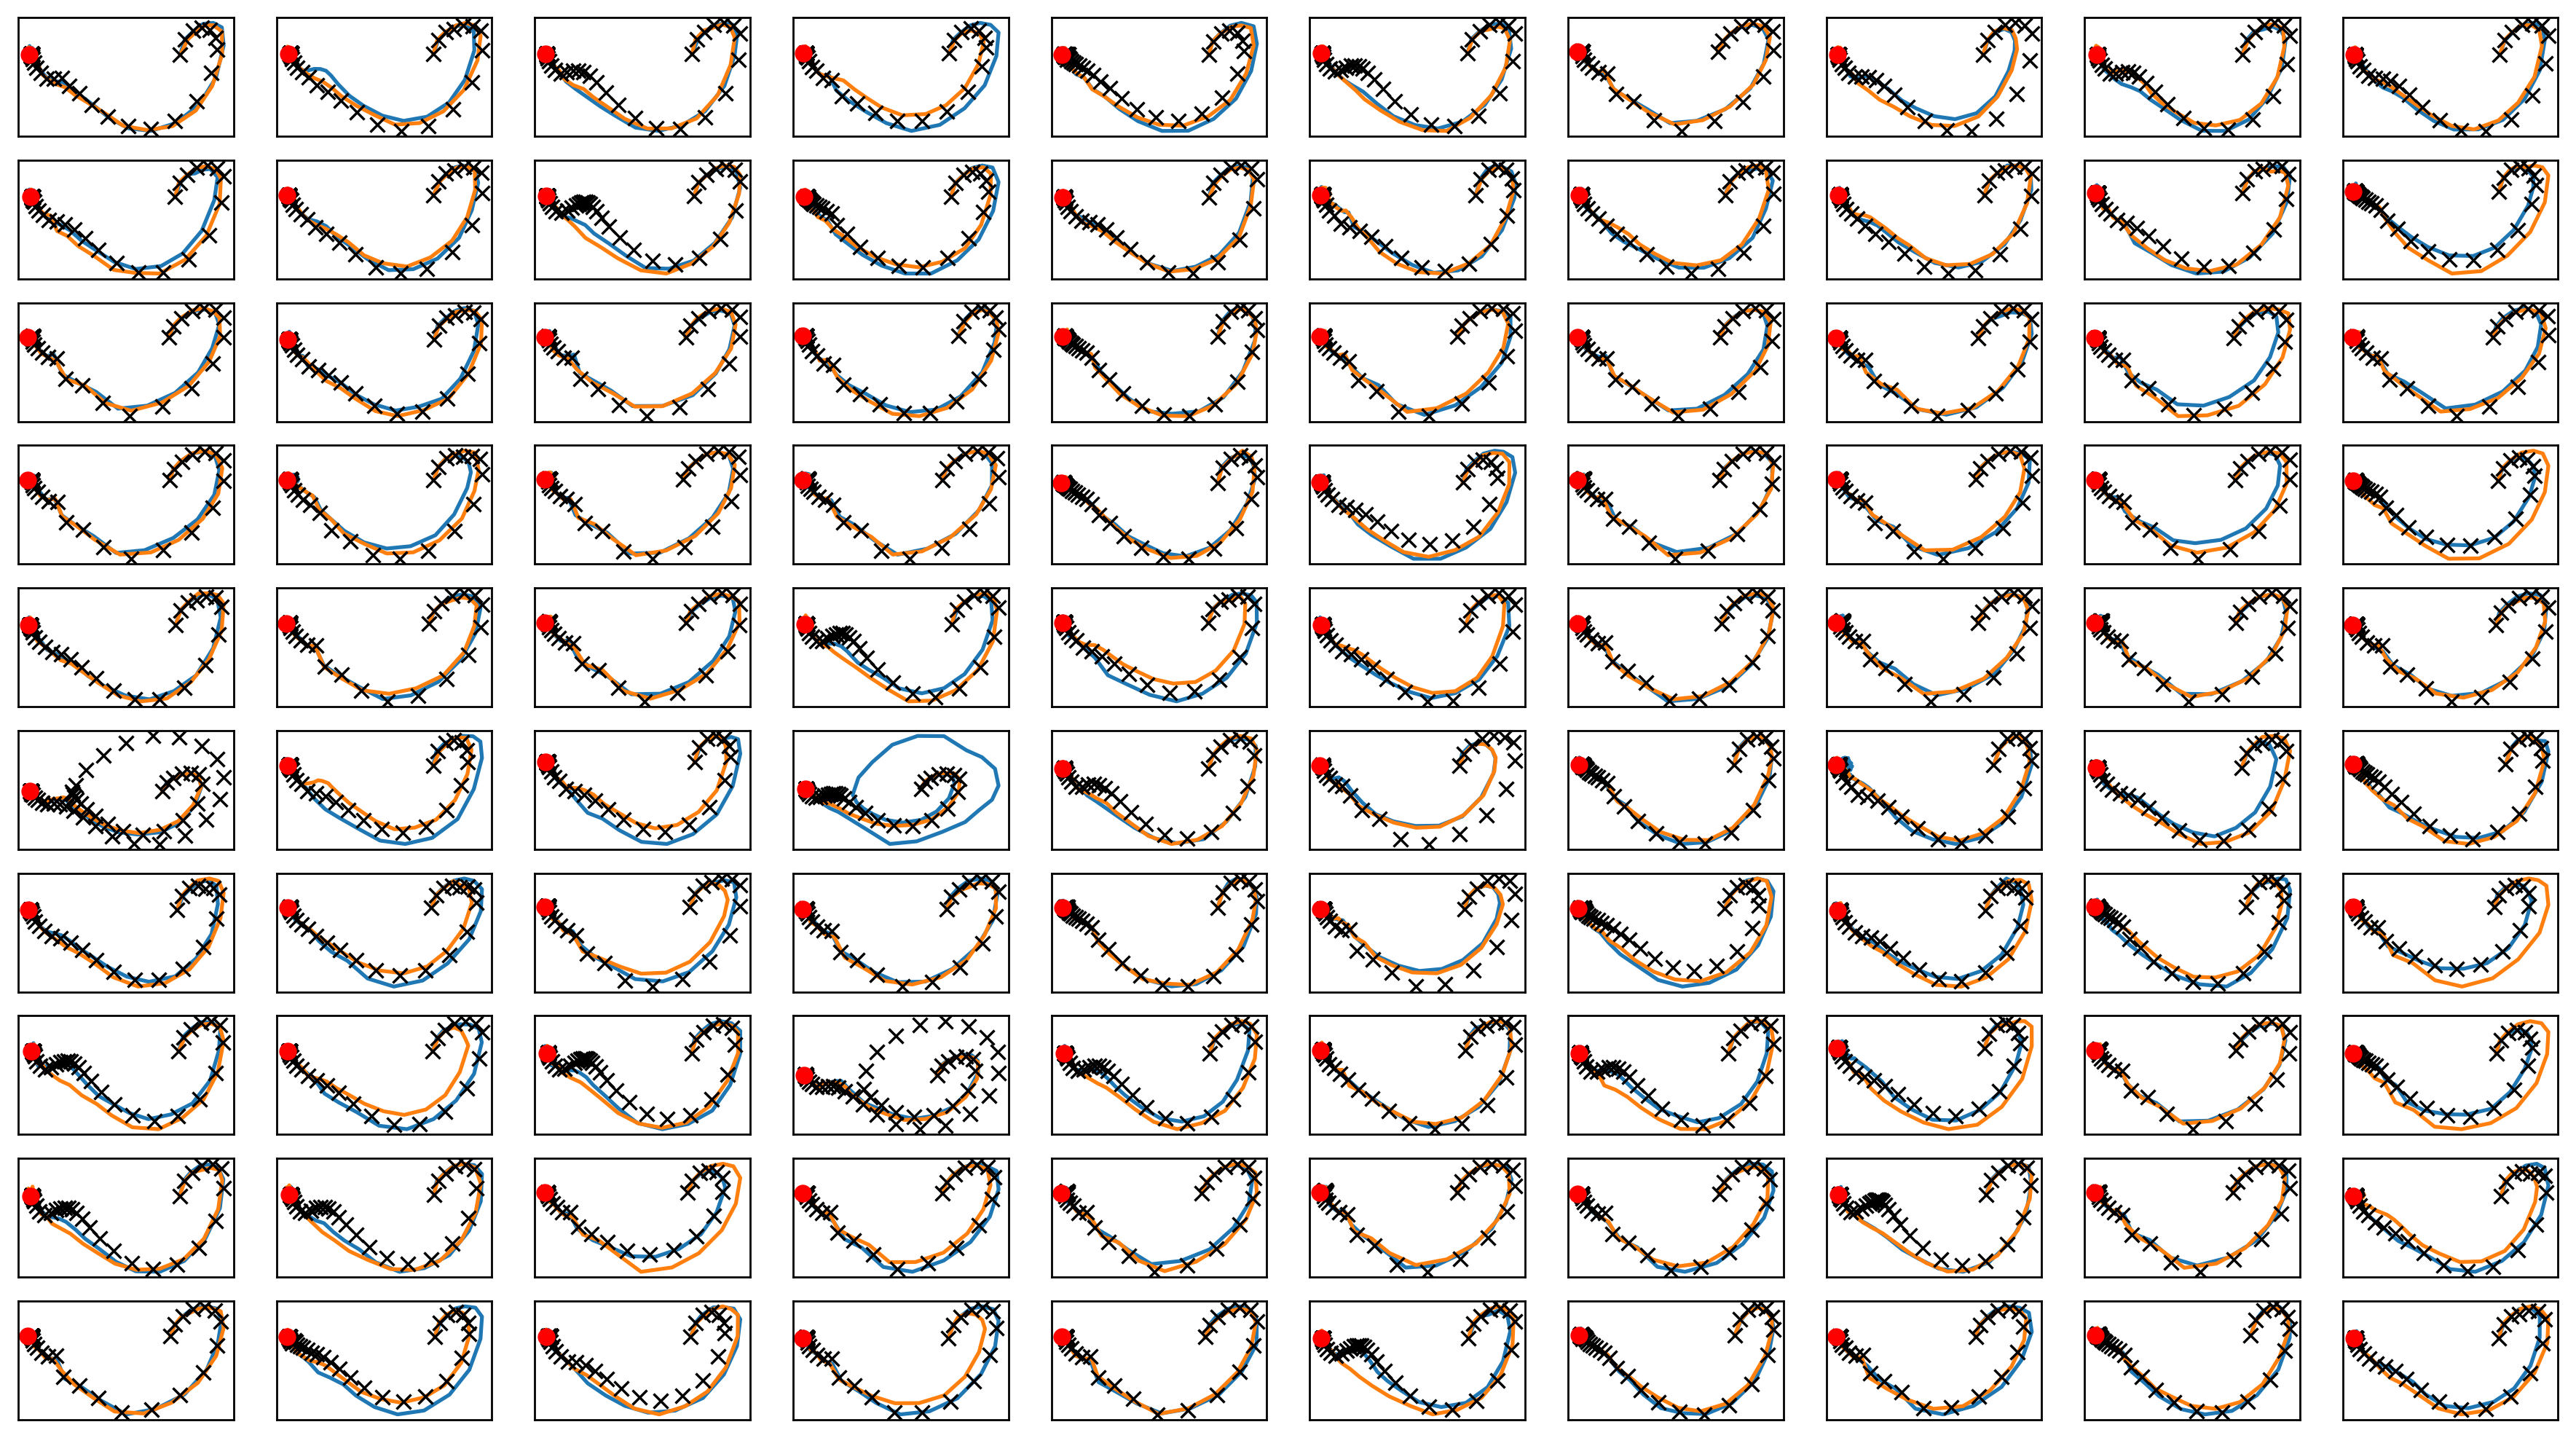

In [9]:

fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
#     ax_list[-1].plot(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1],"kx") 
#     ax_list[-1].plot(iwvi.simenv_rolloutdata[i][:,0], iwvi.simenv_rolloutdata[i][:,1],"o") 
    ax_list[-1].plot(simdata0a[i][:,0], simdata0a[i][:,1]) 
    ax_list[-1].plot(simdata0b[i][:,0], simdata0b[i][:,1]) 
#     ax_list[-1].plot(simdata0c[i][:,0], simdata0c[i][:,1]) 

    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro")
plt.savefig(figfilenamehead+"iter0.png")
# plt.savefig(figfilenamehead+"iter0.pdf")
plt.savefig(figfilenamehead+"iter0.eps")
print("実環境方策rollout vs Sim環境方策rollout")

In [10]:
print(datetime.datetime.now())

2023-05-19 19:09:02.812872
